<a href="https://colab.research.google.com/github/janxl/colabs/blob/master/MeshObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline
!pip install trimesh
!pip install pyrender

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import os
import numpy as np
import trimesh
import pyrender
import matplotlib.pyplot as plt
import json
import urllib.request
import cv2
import re
import glob
import skimage as ski
from skimage import io
import skimage.draw
from tqdm import tqdm 
from PIL import Image, ImageOps
import shutil 
os.environ["PYOPENGL_PLATFORM"] = "egl"
baseUrl = "https://raw.githubusercontent.com/janxl/colabs/master/meshobjectdetection/"

In [ ]:
obj_scene = trimesh.load_remote(baseUrl + 'export.obj')
obj_scene.show()

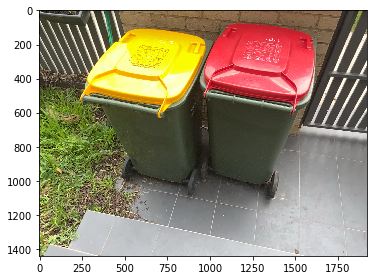

w:1920 h:1440


In [ ]:
filename = baseUrl + 'frame_00019'
photo = io.imread(filename + ".jpg")
io.imshow(photo)
io.show()
img_h, img_w, nrC = photo.shape
print("w:{} h:{}".format(img_w,img_h))

In [ ]:

response = urllib.request.urlopen(filename + ".json")
data = json.loads(response.read().decode())
camera_pose = data['cameraPoseARFrame']
camera_pose = np.array(camera_pose).reshape([4,4])
proj_m = data['projectionMatrix']
proj_m = np.array(proj_m).reshape([4,4])
yfov_radians = 2*math.atan(1./proj_m[1][1])
view_m = np.linalg.inv(camera_pose)
mvp = np.dot(proj_m, view_m)
print(camera_pose)
print(proj_m)
print("yfov:{}".format(yfov_radians))
print(mvp)


[[-0.9997704  -0.01575893 -0.01451242 -2.08494544]
 [-0.02120131  0.63056266  0.77584863  1.69929254]
 [-0.00307555  0.77597827 -0.63075209 -1.74660969]
 [ 0.          0.          0.          1.        ]]
[[ 1.65928864e+00  0.00000000e+00  1.57160163e-02  0.00000000e+00]
 [ 0.00000000e+00  2.21238494e+00 -1.70893669e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -9.99999762e-01 -9.99999815e-04]
 [ 0.00000000e+00  0.00000000e+00 -1.00000000e+00  0.00000000e+00]]
yfov:0.8490332716808028
[[-1.65913607 -0.02298583 -0.01501615 -3.44637588]
 [-0.03461682  1.38178879  1.72754193  0.59710391]
 [ 0.01451242 -0.77584854  0.63075197  2.44932876]
 [ 0.01451243 -0.77584873  0.63075212  2.45032935]]


In [ ]:

obj_mesh = pyrender.Mesh.from_trimesh(obj_scene)
obj_mesh.primitives[0].material.doubleSided = True

mat = obj_mesh.primitives[0].material
mat.wireframe = True
mat.baseColorFactor = np.array([1,1,1,1], dtype=np.float)


In [ ]:
if(renderer):
  renderer.delete() #reset if already exists
scene = pyrender.Scene(ambient_light=[1.15, 1.15, 1.15],
                       bg_color=[0, 0, 0])
scene.add(obj_mesh)
camera = pyrender.PerspectiveCamera(yfov = yfov_radians)
scene.add(camera, pose=camera_pose)
light = pyrender.PointLight(intensity=1.3)
scene.add(light, pose=np.eye(4))
renderer = pyrender.OffscreenRenderer(img_w, img_h)

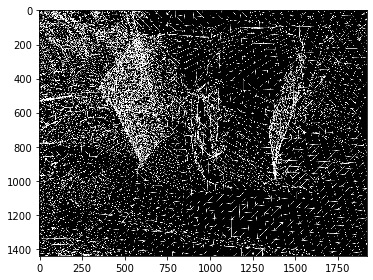

In [ ]:
color_img, depth = renderer.render(scene)
ski.io.imshow(color_img)
ski.io.show()

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


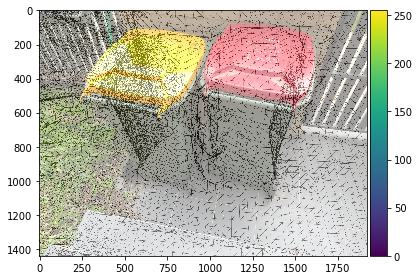

In [ ]:
alpha = 0.5
inverted = ski.util.invert(color_img)
blended =  np.floor(alpha*photo + (1-alpha)*inverted)
blended = blended.astype(int)

ski.io.imshow(blended)
ski.io.show()

In [ ]:
bboxs = []
response = urllib.request.urlopen(baseUrl + "ai.json")
aidata = json.loads(response.read().decode())
objects = aidata['localizedObjectAnnotations']
for poly in objects:
  vertices = poly['boundingPoly']['normalizedVertices']
  ul = (int(vertices[0]['x']*img_w),int(vertices[0]['y']*img_h))
  lr = (int(vertices[2]['x']*img_w),int(vertices[2]['y']*img_h))
  bboxs.append([ul,lr])
print(bboxs)

[[(241, 101), (1002, 1060)], [(935, 74), (1599, 1088)]]


[(241, 101), (1002, 1060)]
[(935, 74), (1599, 1088)]


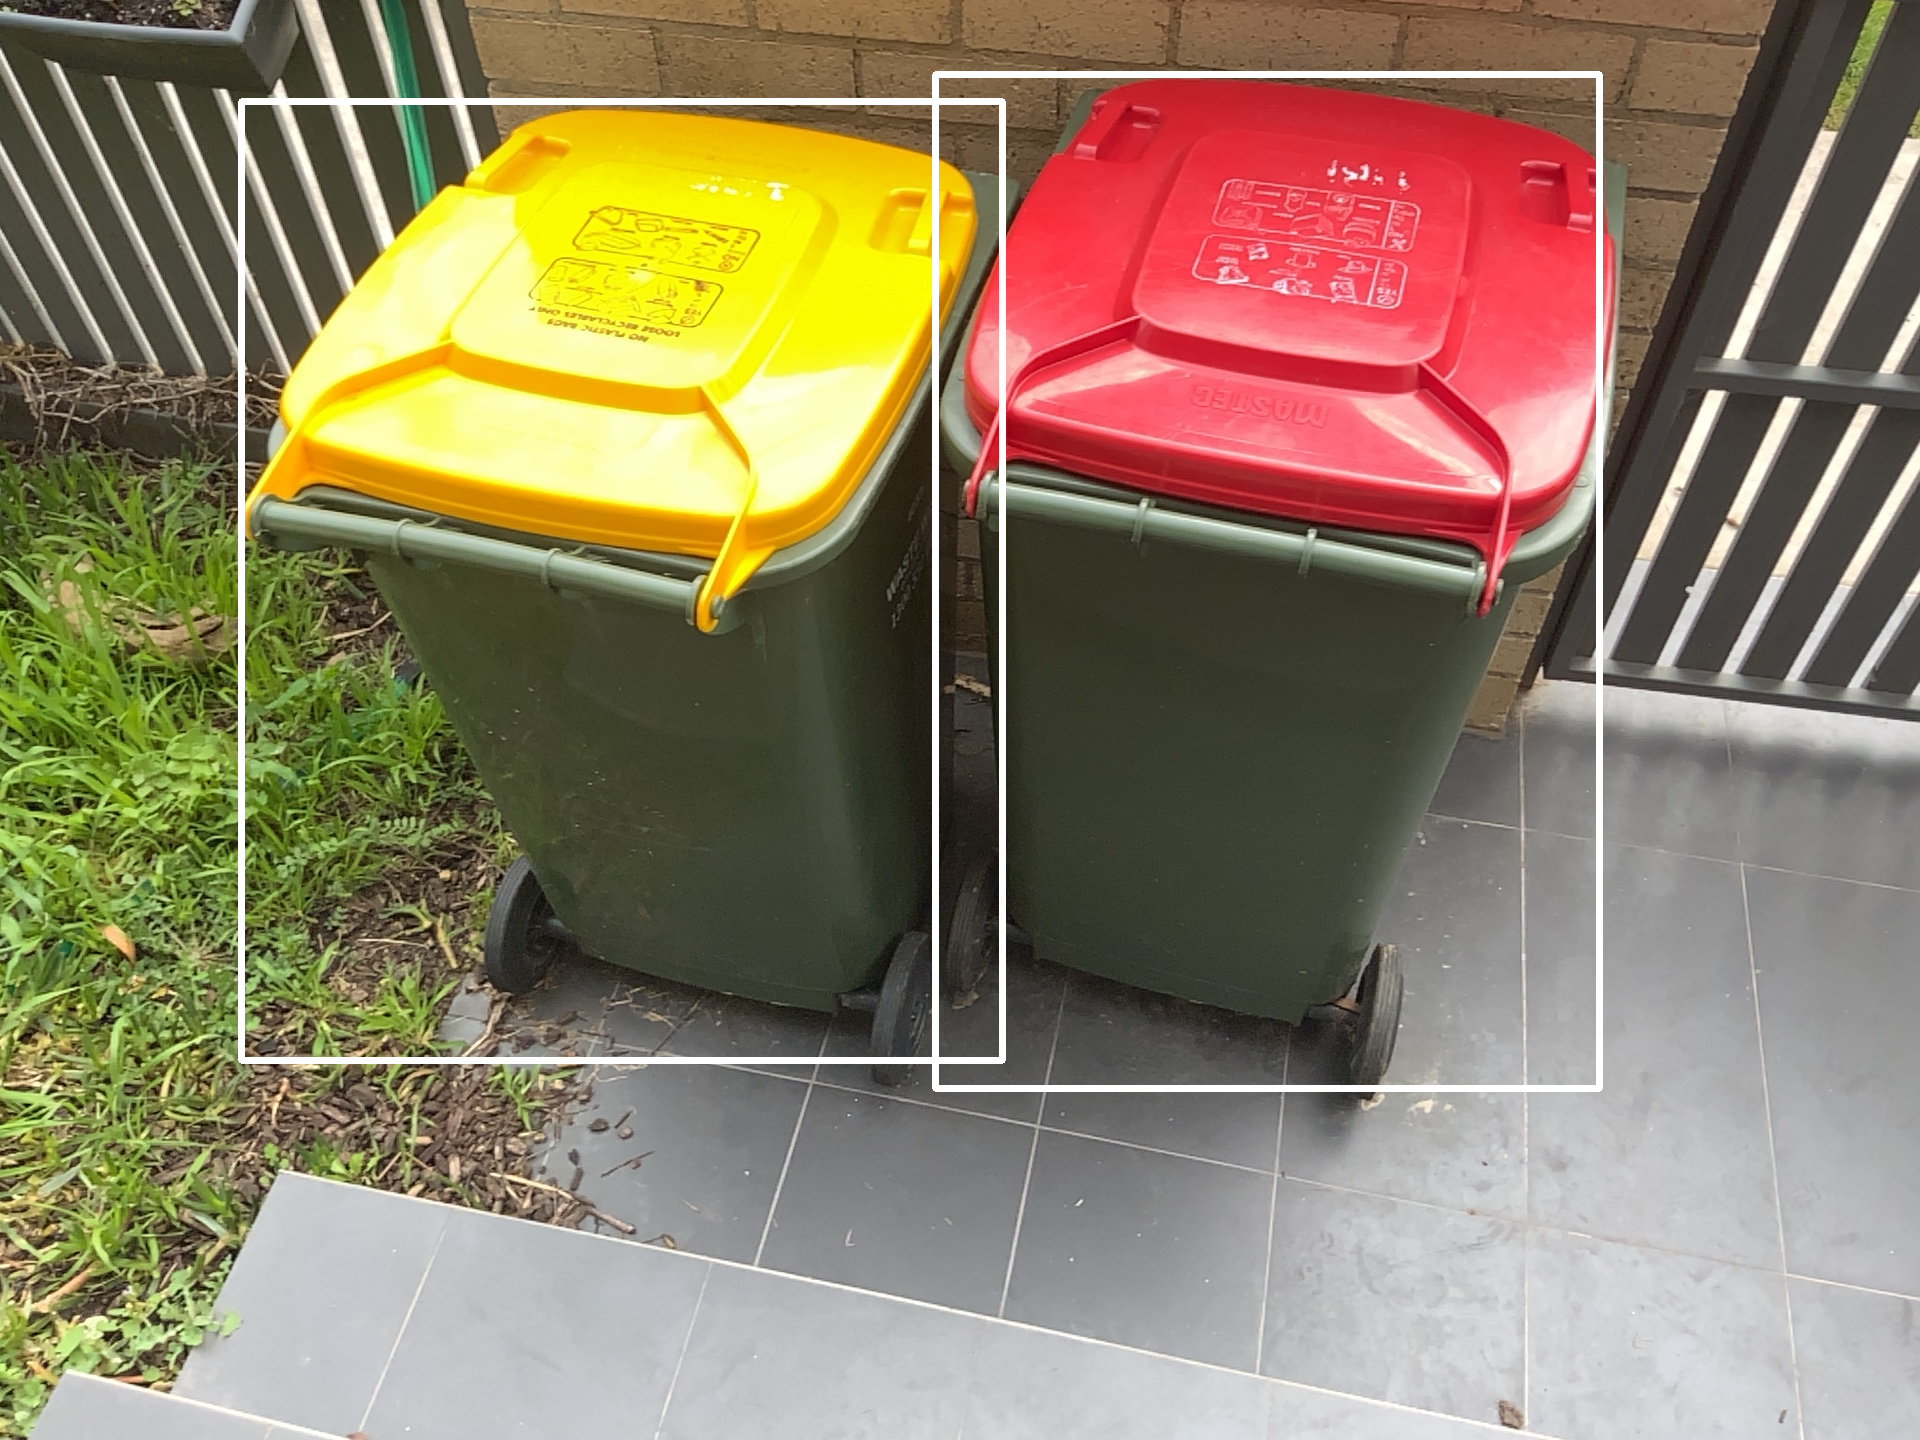

In [ ]:
from google.colab.patches import cv2_imshow

response = urllib.request.urlopen(filename + ".jpg")
np_img = np.asarray(bytearray(response.read()), dtype="uint8")
bbox = cv2.imdecode(np_img, cv2.IMREAD_COLOR)
color = (255, 255, 255)
thickness =5
for bb in bboxs:
  bbox = cv2.rectangle(bbox, bb[0], bb[1], color, thickness) 
cv2_imshow(bbox)


In [ ]:
def project_point_mvp(p_in, mvp, image_width, image_height):
    p0 = np.append(p_in, [1])
    e0 = np.dot(mvp, p0)
    e0[:3] /= e0[3]
    pos_x = e0[0]
    pos_y = e0[1]
    px = (0.5 + (pos_x) * 0.5) * image_width
    py = (1.0 - (0.5 + (pos_y) * 0.5)) * image_height
    return int(round(px)), int(round(py))

In [ ]:
def is_2dpoint_in_bbox(p2d, bbox):
    if(p2d[0]>bbox[0][0] and p2d[0]<bbox[1][0]):
      if(p2d[1]>bbox[0][1] and p2d[1]<bbox[1][1]):
        return True
    return False

In [ ]:
vs = []
fs = []
for f in obj_scene.faces:
  for iv in f:
    v= obj_scene.vertices[iv]
    p2d = project_point_mvp(v, mvp, img_w, img_h)
    isIn = is_2dpoint_in_bbox(p2d, bboxs[0])
    if(isIn):
      for iv in f:
        vs.append(obj_scene.vertices[iv])
      fs.append([len(vs)-3, len(vs)-2, len(vs)-1])
      break

In [ ]:
bboxMesh = trimesh.Trimesh(vertices=vs, faces=fs)
bboxMesh.remove_duplicate_faces()
objs_mesh = bboxMesh.split(only_watertight=False)
maxO = 0
obj = None
for o in objs_mesh:
  if(o.vertices.shape[0]>maxO):
    maxO = o.vertices.shape[0]
    obj = o
obj.show()

face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_normals all zero, ignoring!
face_norma